In [62]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as sp
import pandas as pd

from scCustomFunctions import *
from parameters import *

from sklearn import preprocessing

import os

import pydpc

import warnings
warnings.filterwarnings('ignore')

In [63]:
a = loadData(QC_imputed=True,Normalized=True,Log1p=True)

# Clustering

We cluster the different stages using a couple of different algorithms:

1. Louvain
2. DPC

**Results:** Both algorithms cluster the data visually well and consistently as visually checked on the umap and with very similar results. We stay with the Louvain algorithm as it is more agnostic (DPC works on the 2D UMAP plot) and seems to better represent the partitions of the data.

In [74]:
fig1,ax1 = plt.subplots(5,2,figsize=[20,50])
fig2,ax2 = plt.subplots(5,2,figsize=[20,50])
fig3,ax3 = plt.subplots(5,2,figsize=[20,50])

data = pd.DataFrame(index=a.obs.index.astype(int),columns=["Stage","Sample","Louvain","DPC"])
data.loc[a.obs.index.astype(int),"Stage"] = a.obs["stage"].values
data.loc[a.obs.index.astype(int),"Sample"] = a.obs["sample"].values
for j,stage in enumerate(a.obs["stage"].unique()[:]):
    
    posx = j//2
    posy = j%2
    
    b = a[a.obs["stage"]==stage]
    b.obs["sample"]=b.obs["sample"].astype(str)
    
    #Load data from batch correction    
    b.obsm["X_pca"] = np.load("dataOut/4_Batch_Correction/PCA_"+stage+".npy")
    b.obsm["X_pca_harmony"] = np.load("dataOut/4_Batch_Correction/PCA_harmony_"+stage+".npy")
    b.obsm["X_umap"] = np.load("dataOut/4_Batch_Correction/UMAP_harmony_"+stage+".npy")
    scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS,use_rep="X_pca_harmony")
    
    #Clustering algorithms
    
    ## Louvain
    scp.tl.louvain(b,resolution=LOUVAIN_RESOLUTION)
    data.loc[b.obs.index.astype(int),"Louvain"] = b.obs["louvain"].values    
    
    sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["louvain"],s=10,ax=ax1[posx,posy])
    ax1[posx,posy].set_title(stage,fontsize=20)
    for k in b.obs["louvain"].unique():
        pos = b[b.obs["louvain"]==k,:].obsm["X_umap"]
        pos = np.nan_to_num(pos)
        pos = pos.mean(axis=0)
        ax1[posx,posy].text(pos[0],pos[1],k,fontsize=20,backgroundcolor="grey")
    
    ##DPC
    X = b.obsm["X_umap"].copy(order='C').astype("float64") #Something to make sure that we get the appropiate format so pydpc accepts it
    X_proc = preprocessing.StandardScaler().fit_transform(X)
    cluster = pydpc.Cluster(X_proc,autoplot=False);
    cluster.assign(DPC_CUT_PARAMETERS[0],DPC_CUT_PARAMETERS[1])
    b.obs["DPC"] = cluster.membership.astype(str)
    data.loc[b.obs.index.astype(int),"DPC"] = b.obs["DPC"].values  
    
    sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["DPC"],s=10,ax=ax3[posx,posy])
    ax3[posx,posy].set_title(stage,fontsize=20)
    for k in b.obs["DPC"].unique():
        pos = b[b.obs["DPC"]==k,:].obsm["X_umap"]
        pos = np.nan_to_num(pos)
        pos = pos.mean(axis=0)
        ax3[posx,posy].text(pos[0],pos[1],k,fontsize=20,backgroundcolor="grey")
        
    c = np.greater(cluster.density,DPC_CUT_PARAMETERS[0]) * np.greater(cluster.delta,DPC_CUT_PARAMETERS[1])
    sb.scatterplot(cluster.density,cluster.delta,hue=c,s=10,ax=ax2[posx,posy])
    ax2[posx,posy].set_title(stage,fontsize=20)
        
data.to_csv("Tables/5_Clustering/Clusters.csv")

fig1.savefig("Plots/5_Clustering/Louvain_clusters.png",bbox_inches="tight",transparent=True)
fig2.savefig("Plots/5_Clustering/DPC_scatterplot.png",bbox_inches="tight",transparent=True)
fig3.savefig("Plots/5_Clustering/DCP_cluster.png",bbox_inches="tight",transparent=True)

plt.close(fig1); plt.close(fig2); plt.close(fig3)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


# Create files for manual annotation

For the manual annotation we use the following information:

1. A list of Differentially Expressed genes of each cluster vs. the rest.
2. Plots of gene expression over the UMAP for characteristic genes (to be found in parameters.py).

Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'louvain' as categorical


['Adh1a2', 'Msgn']  don't express


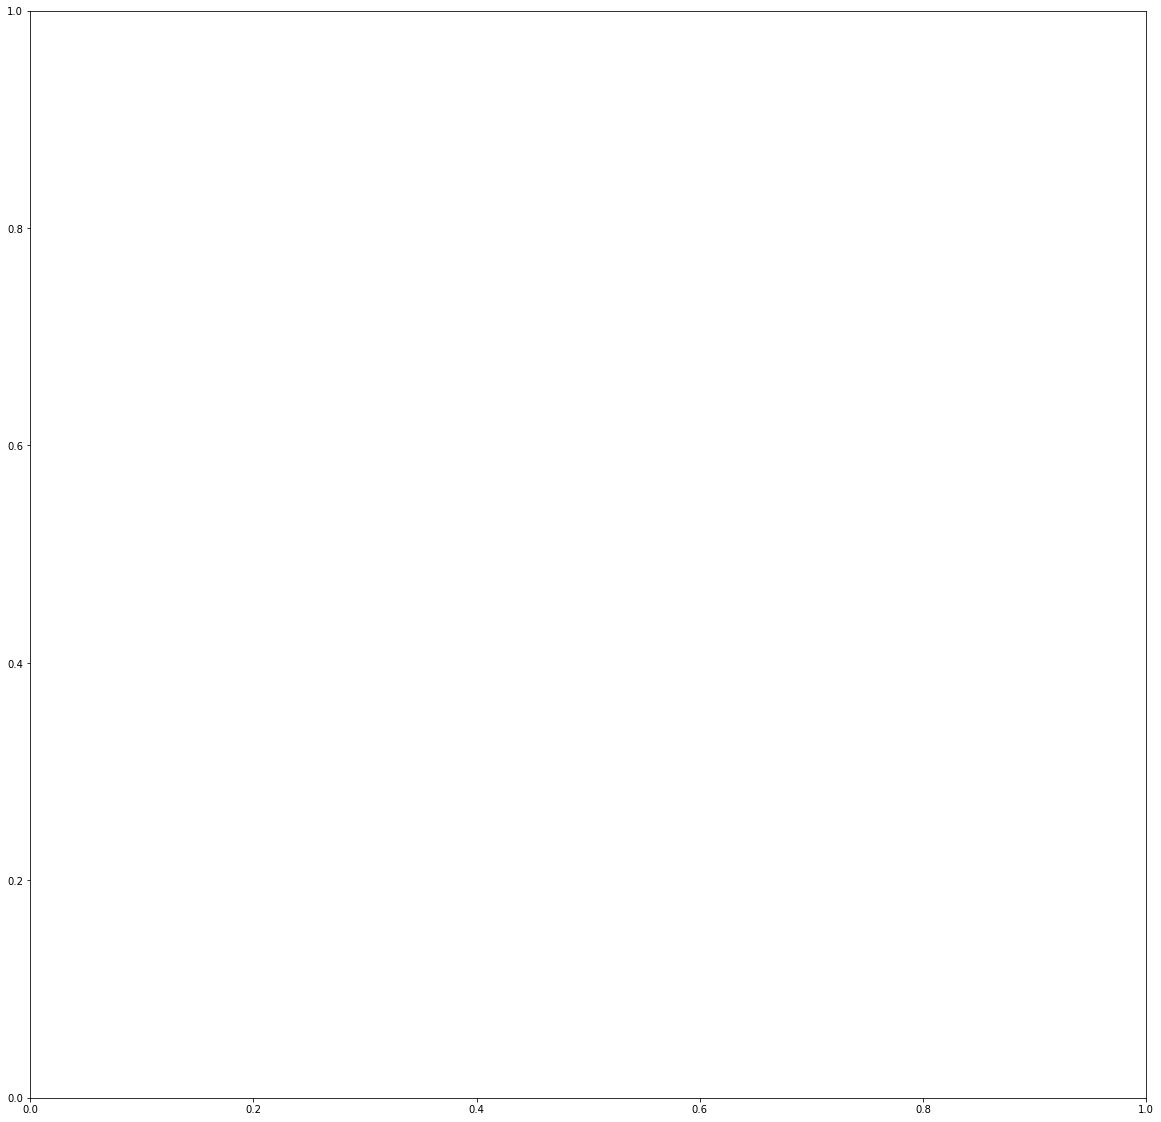

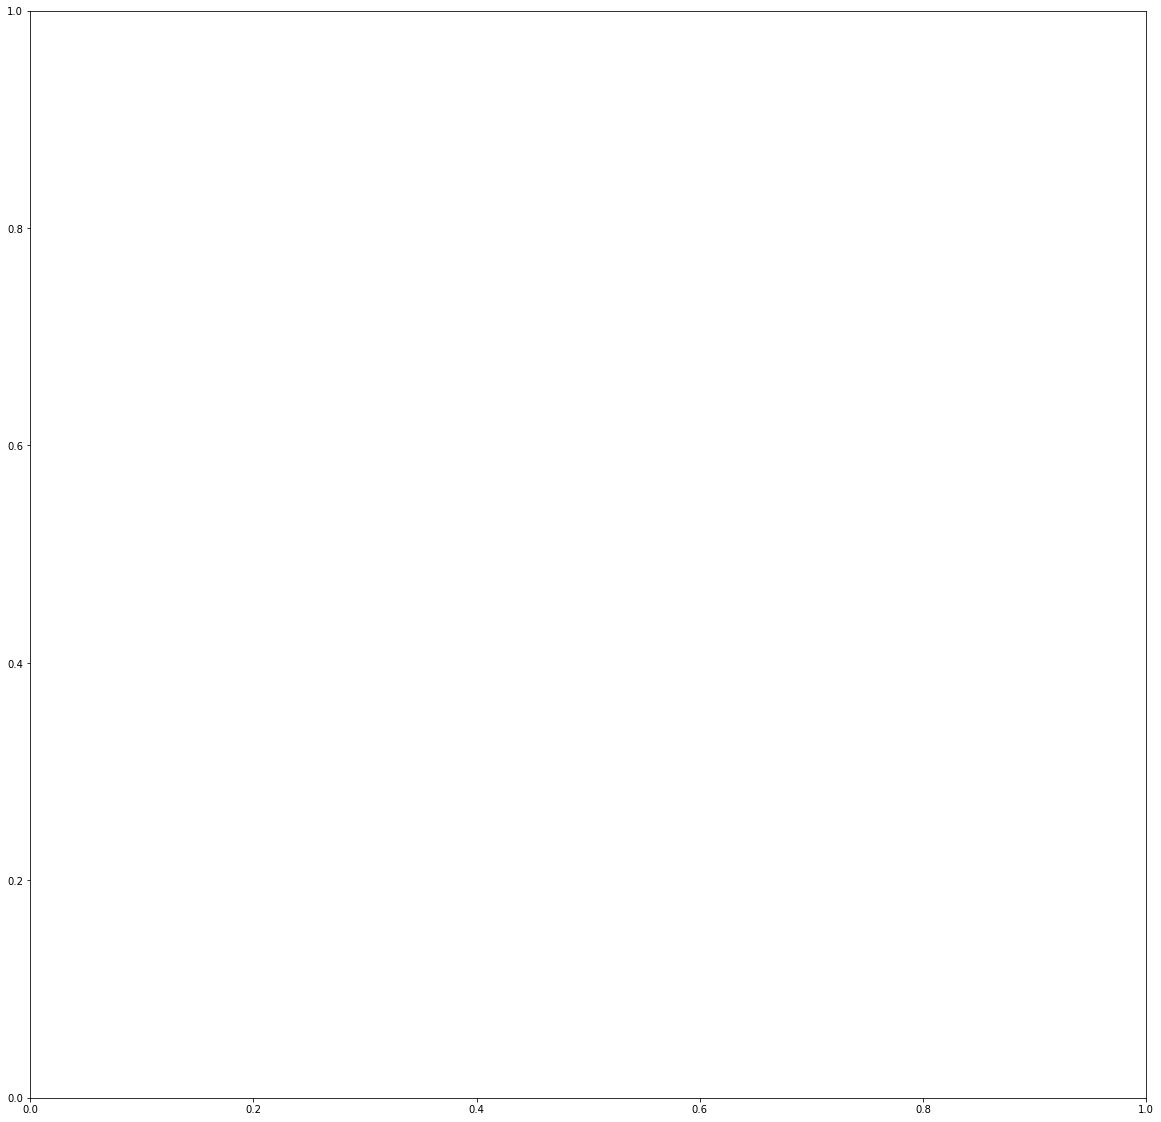

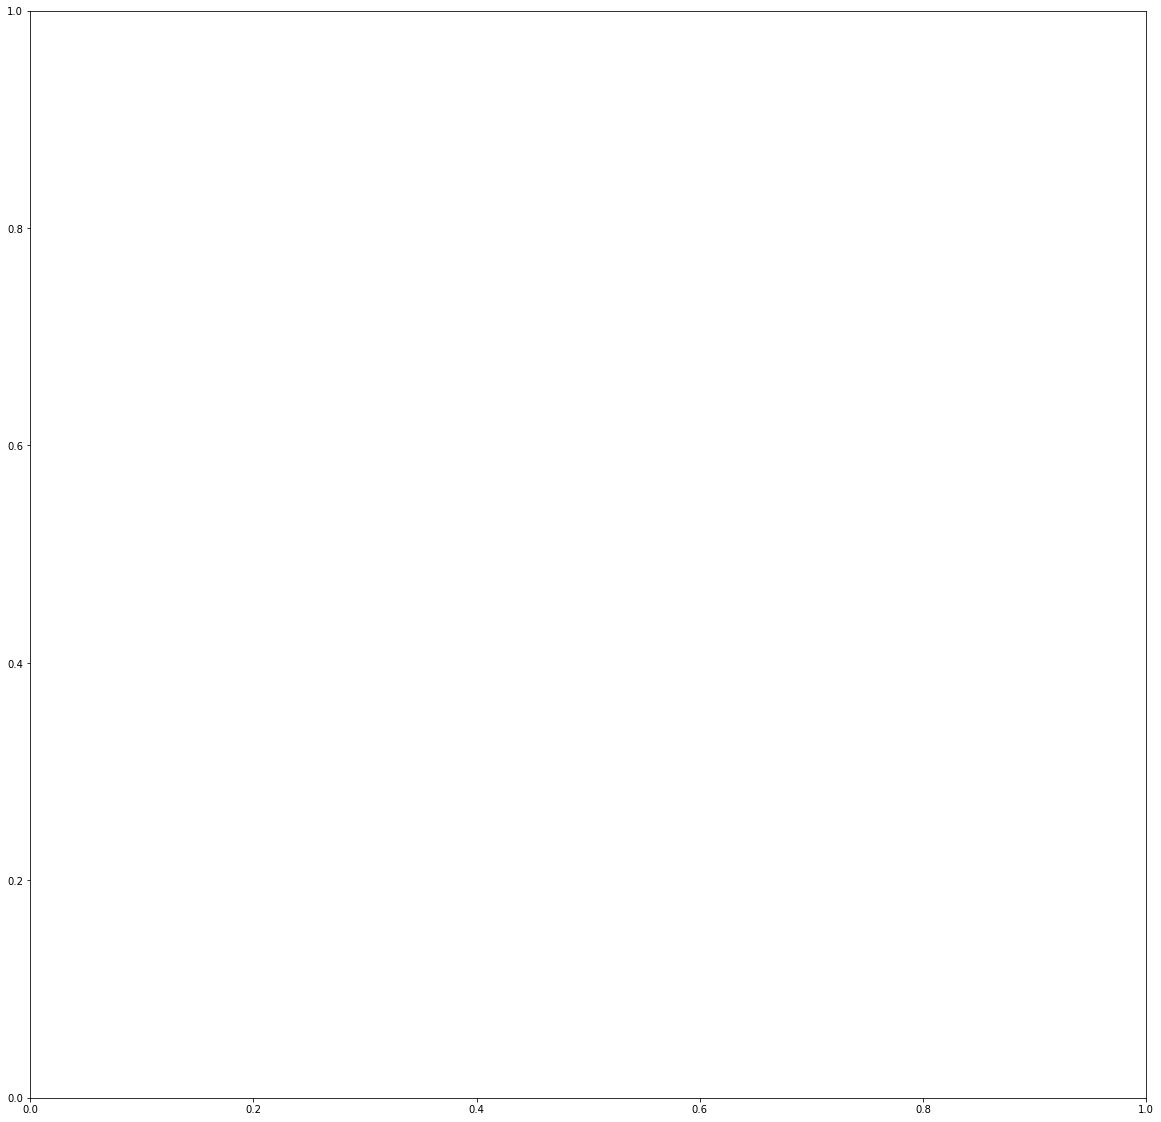

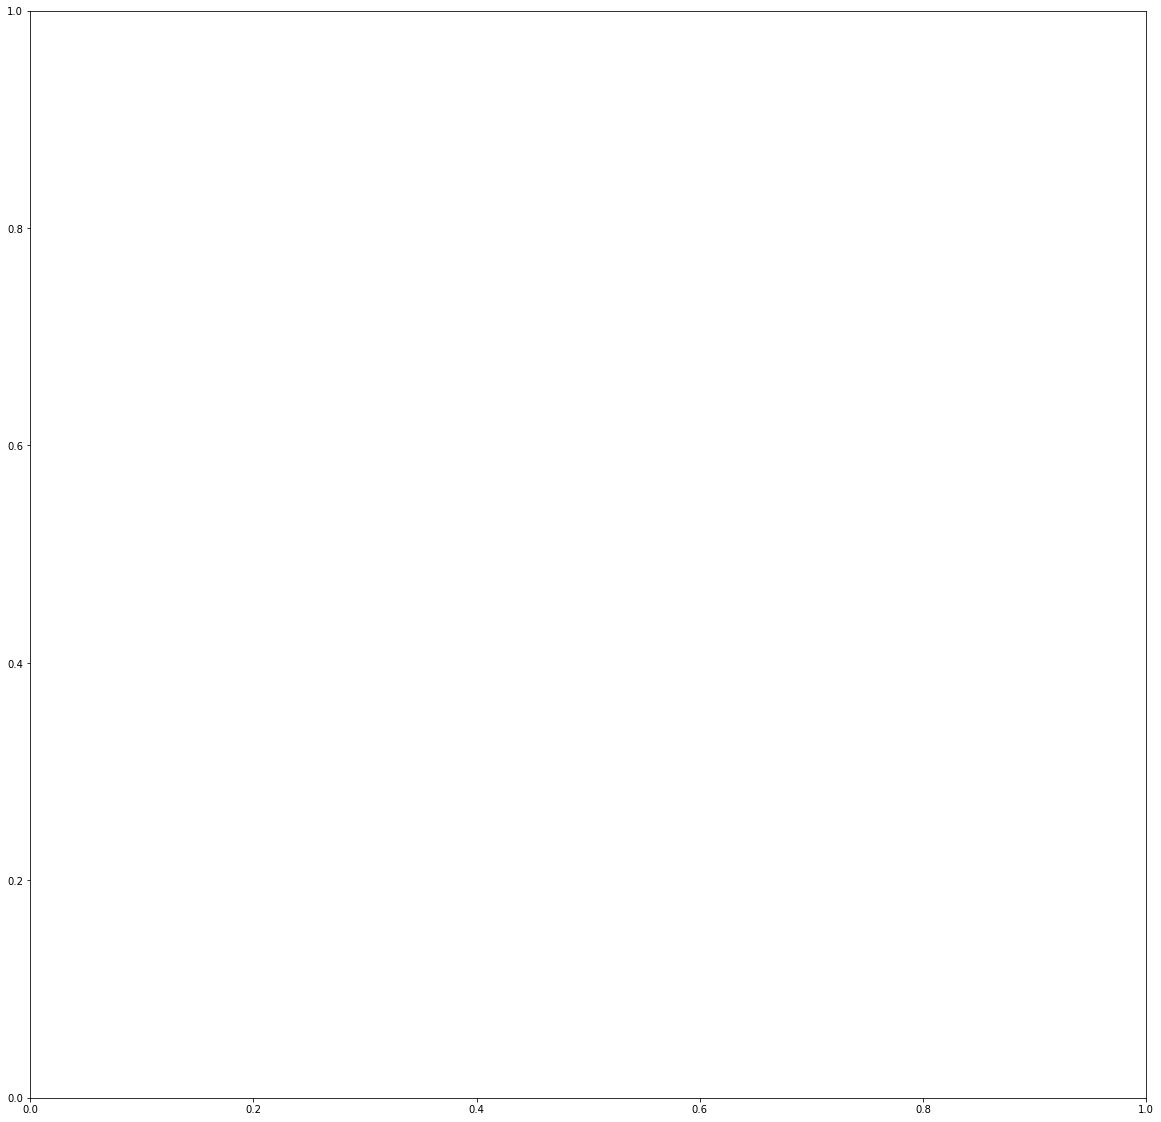

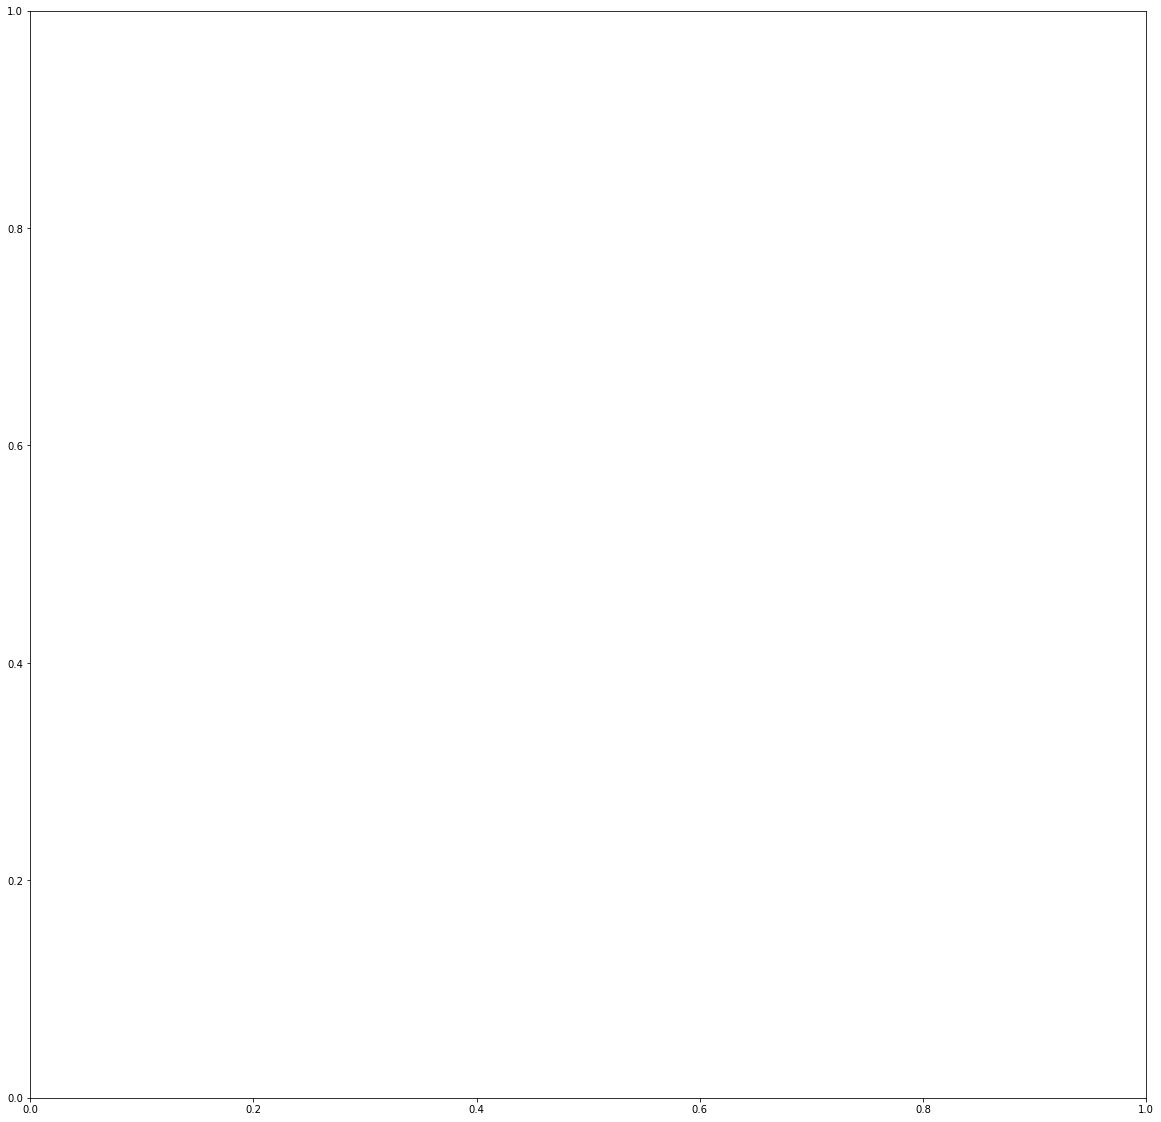

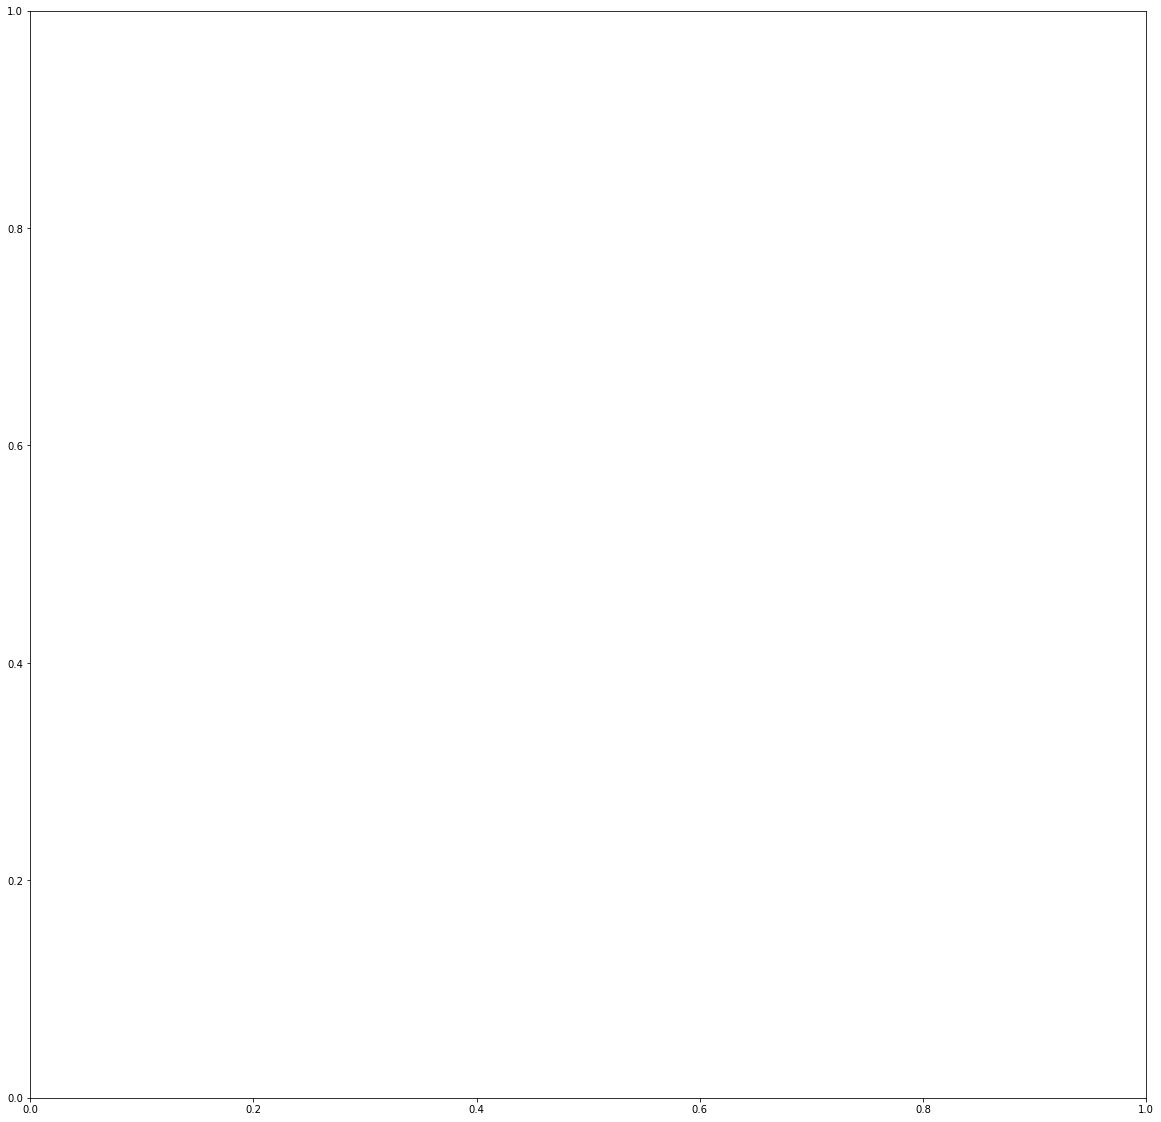

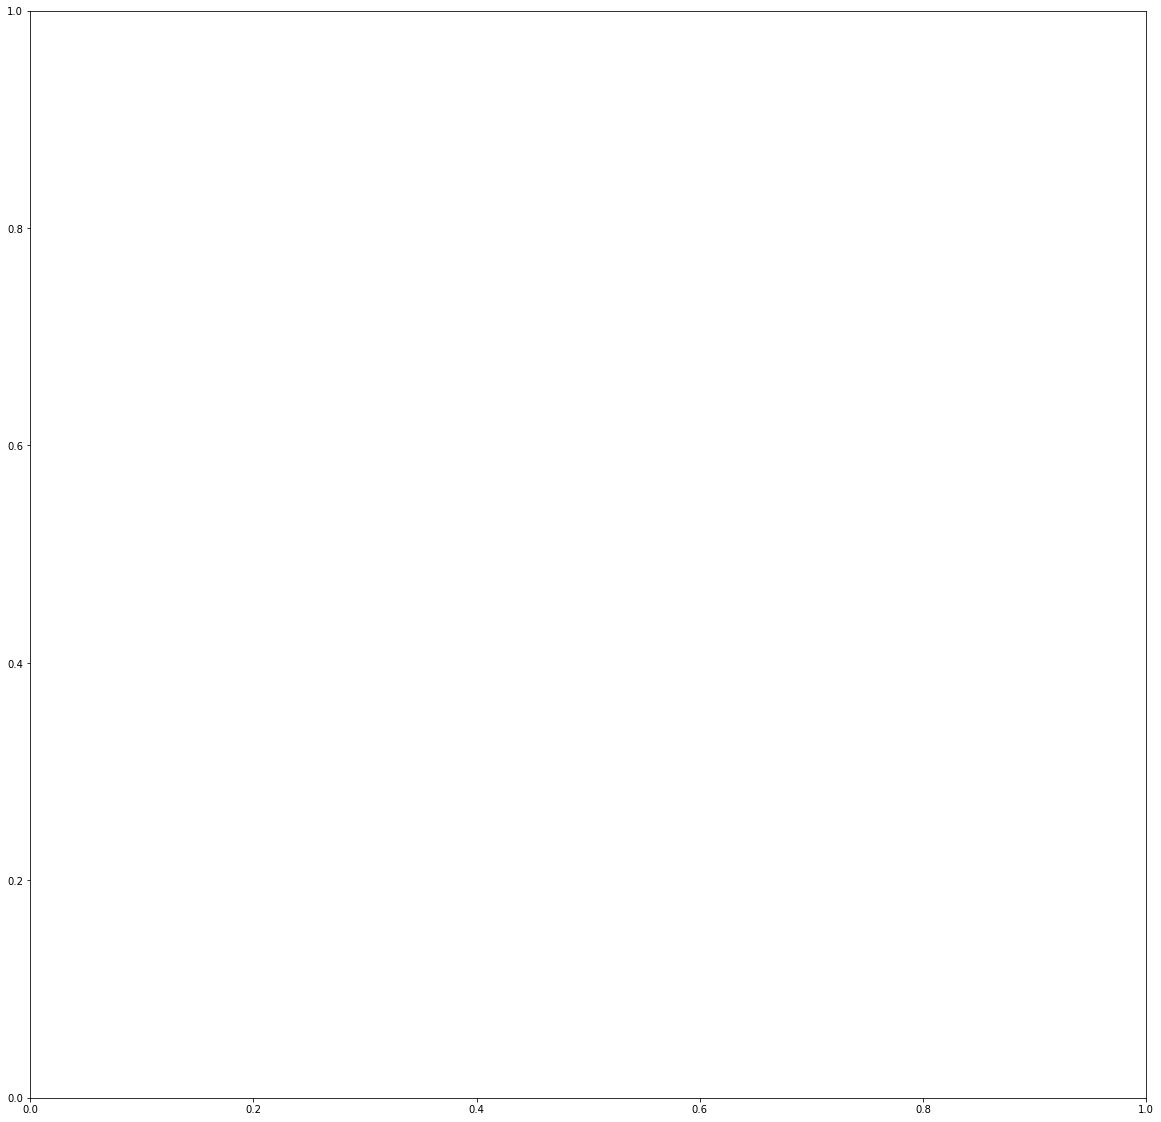

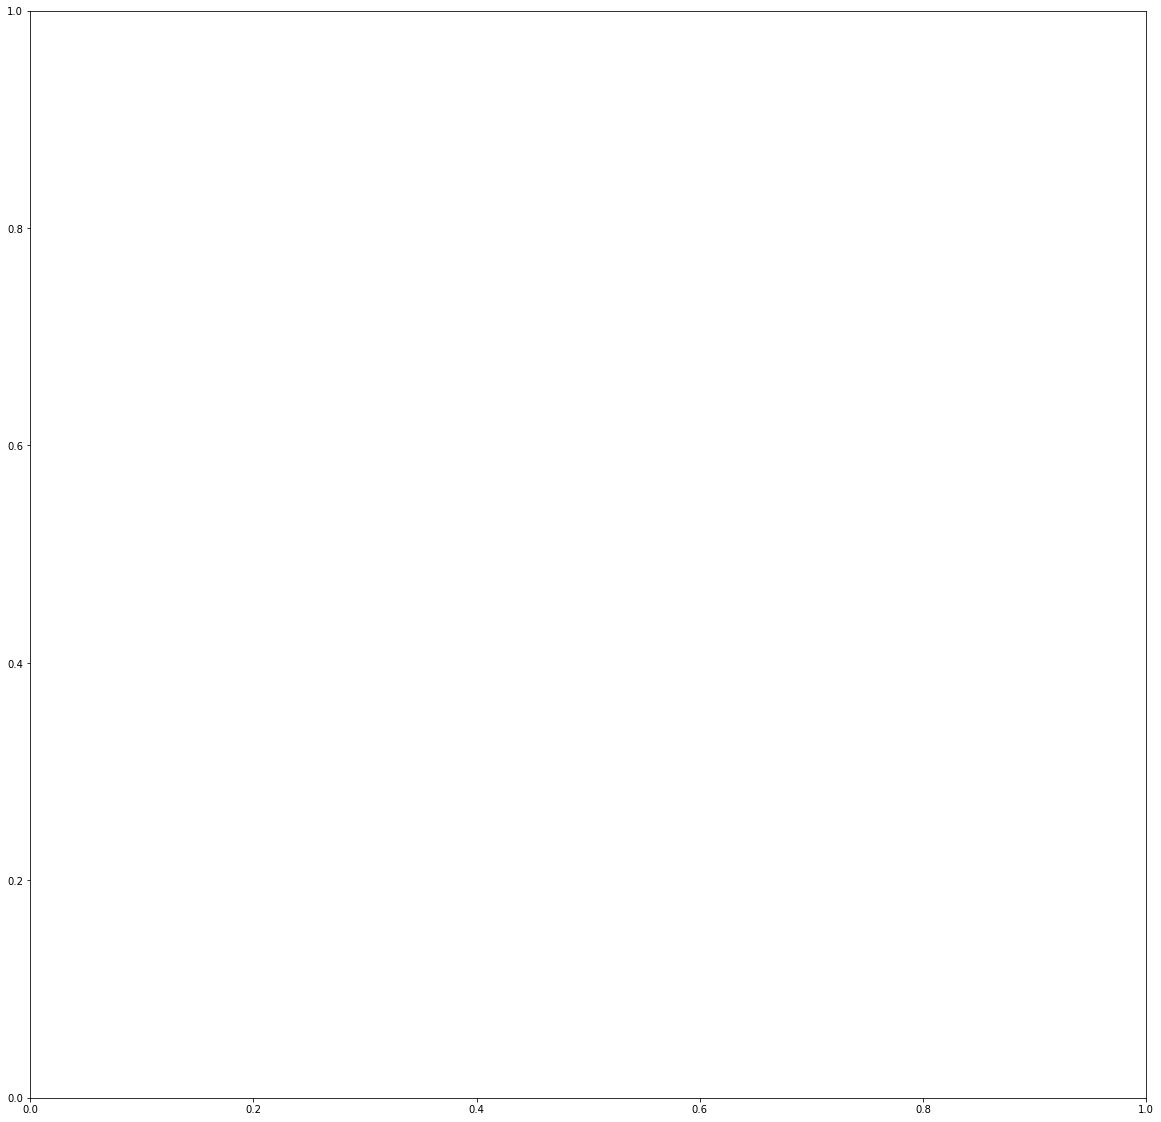

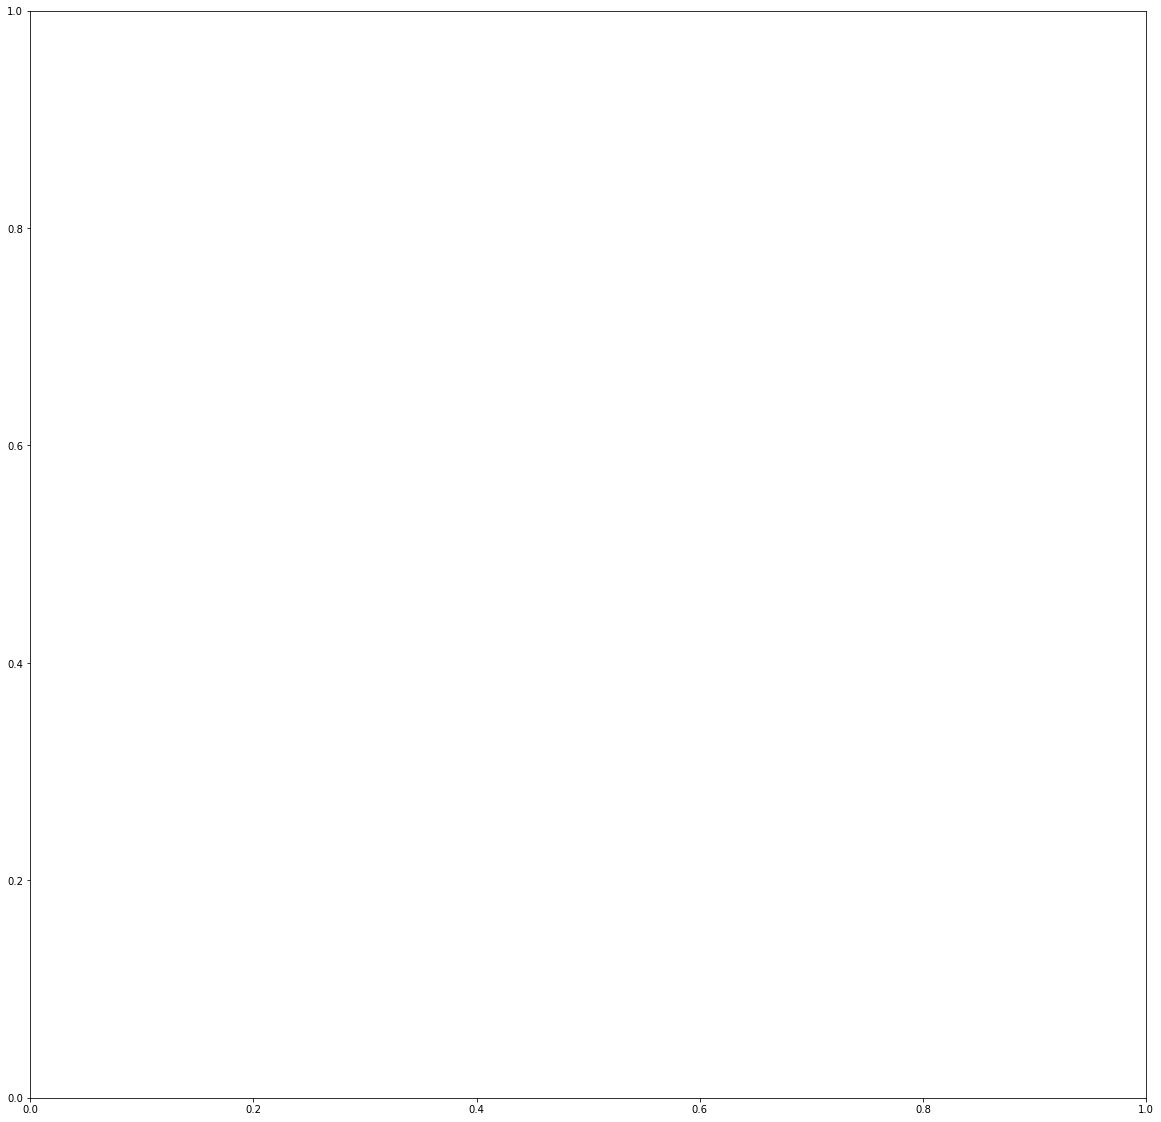

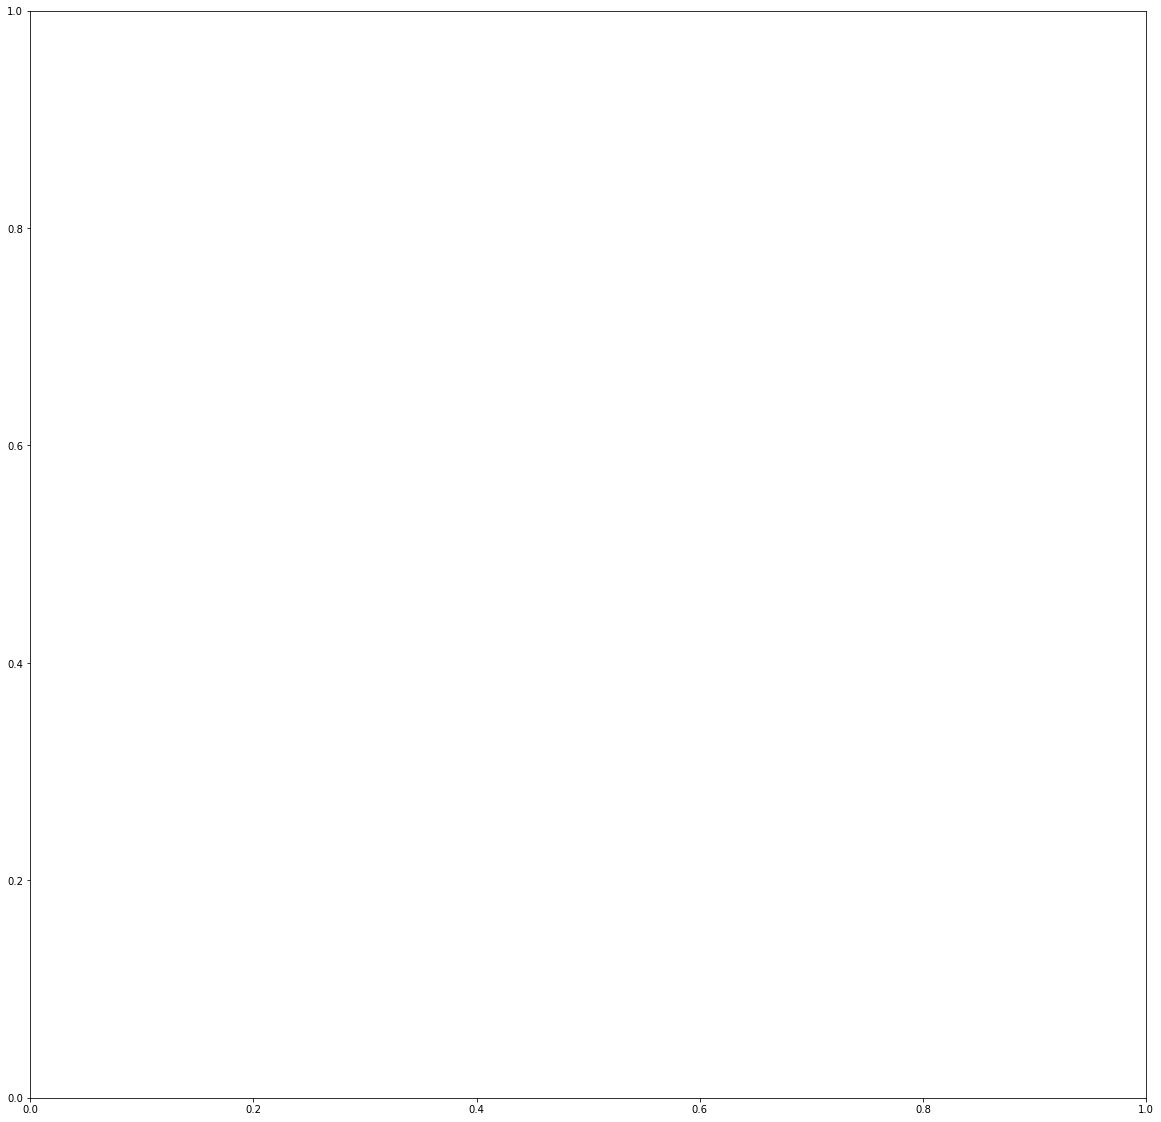

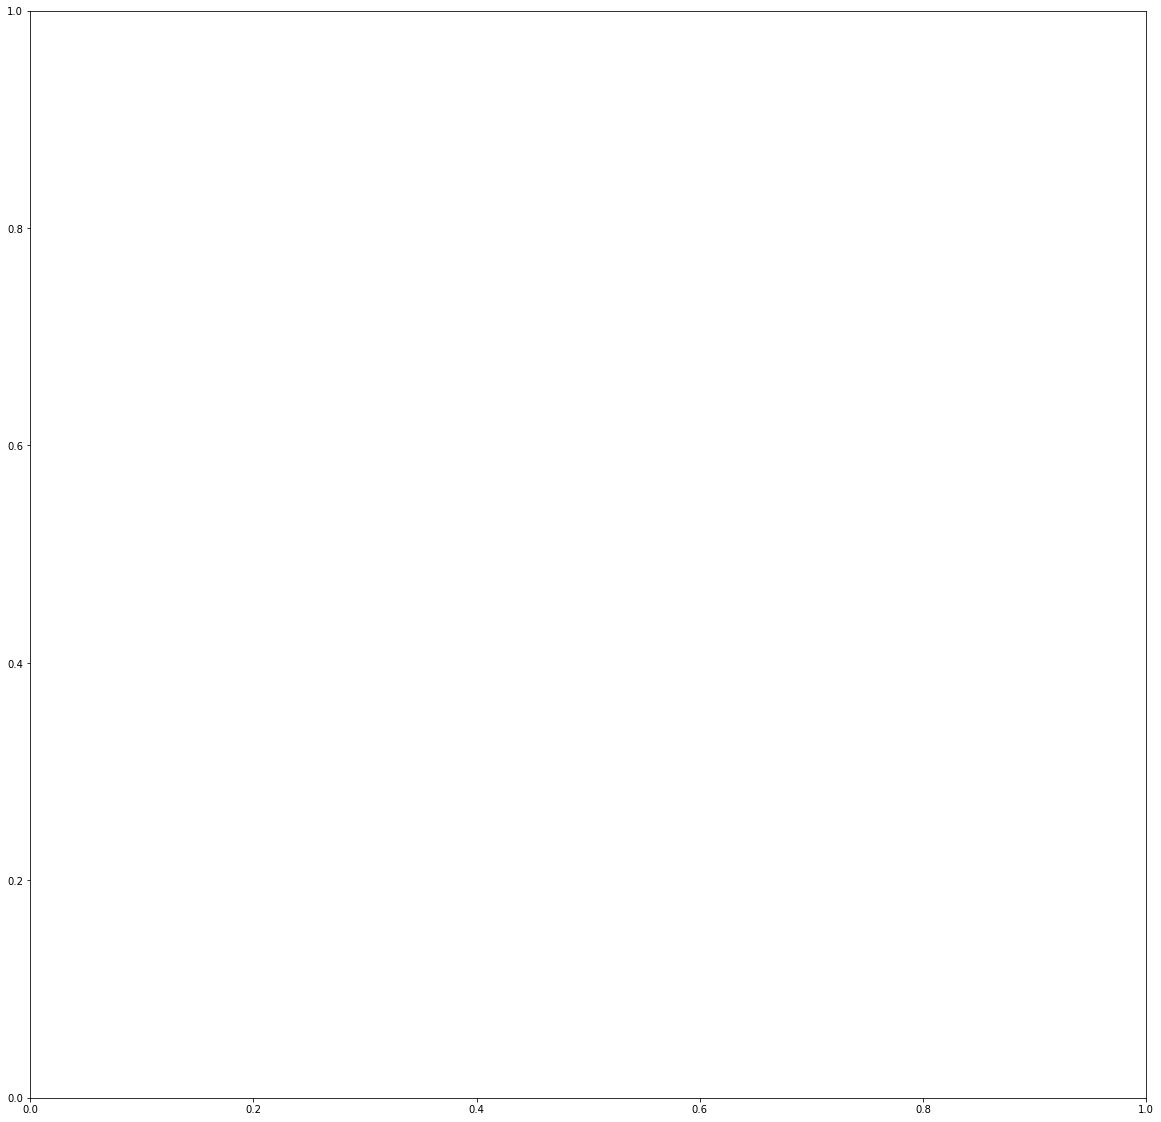

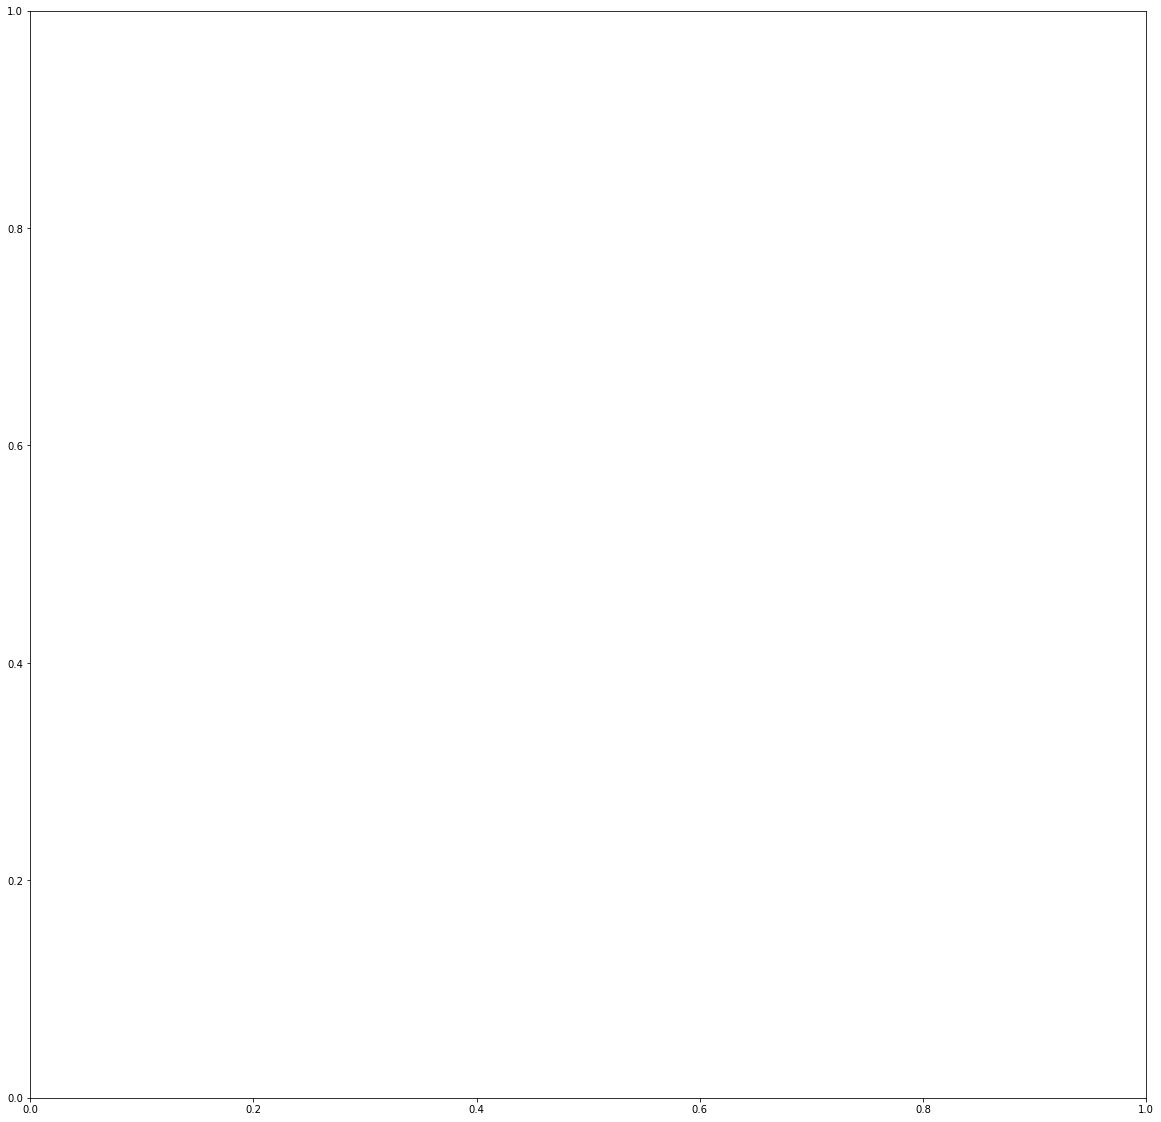

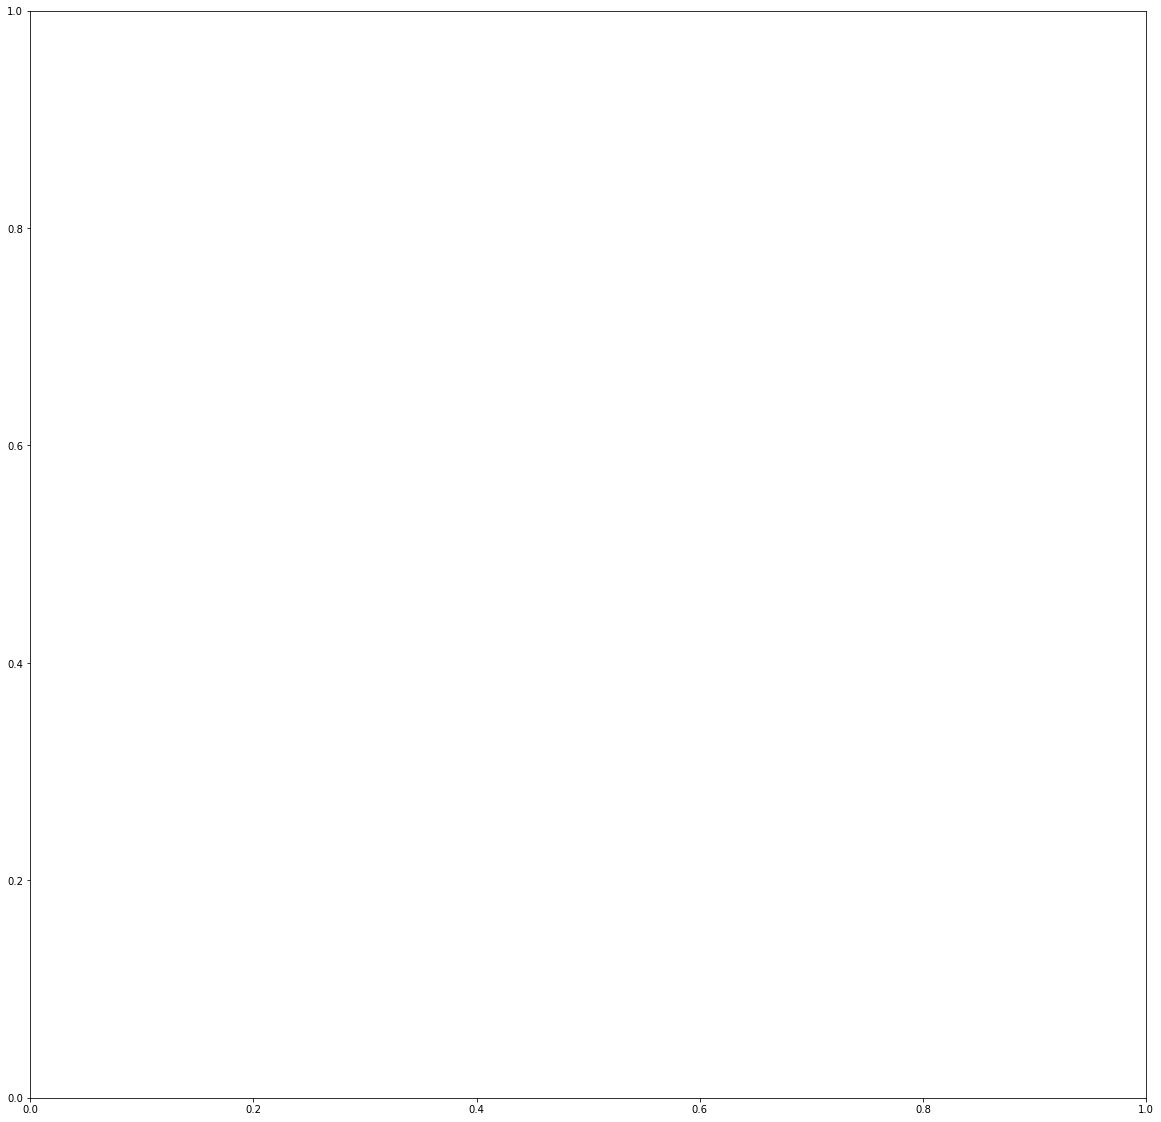

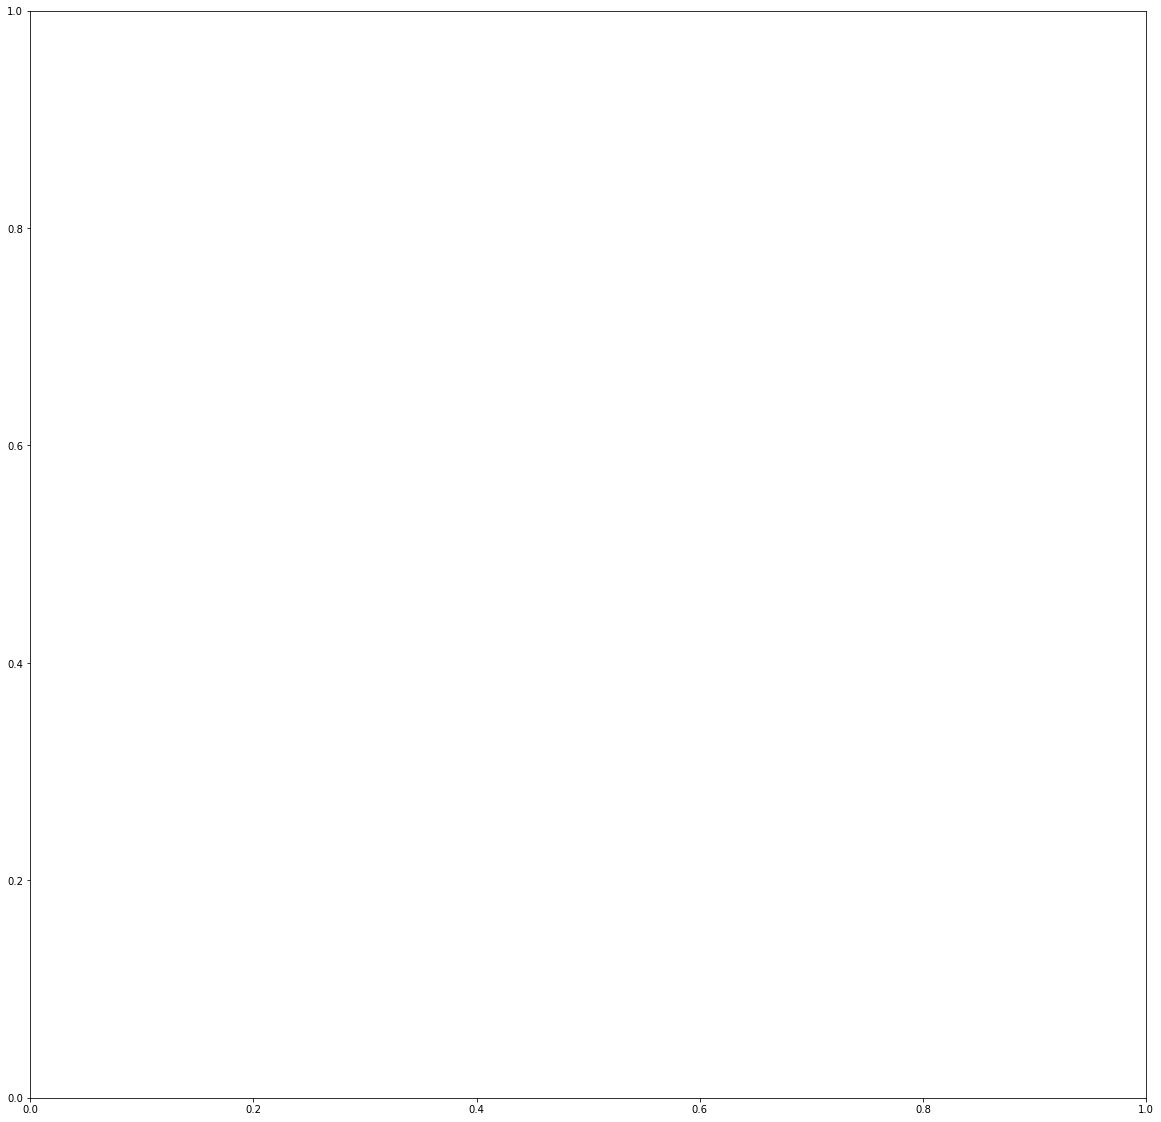

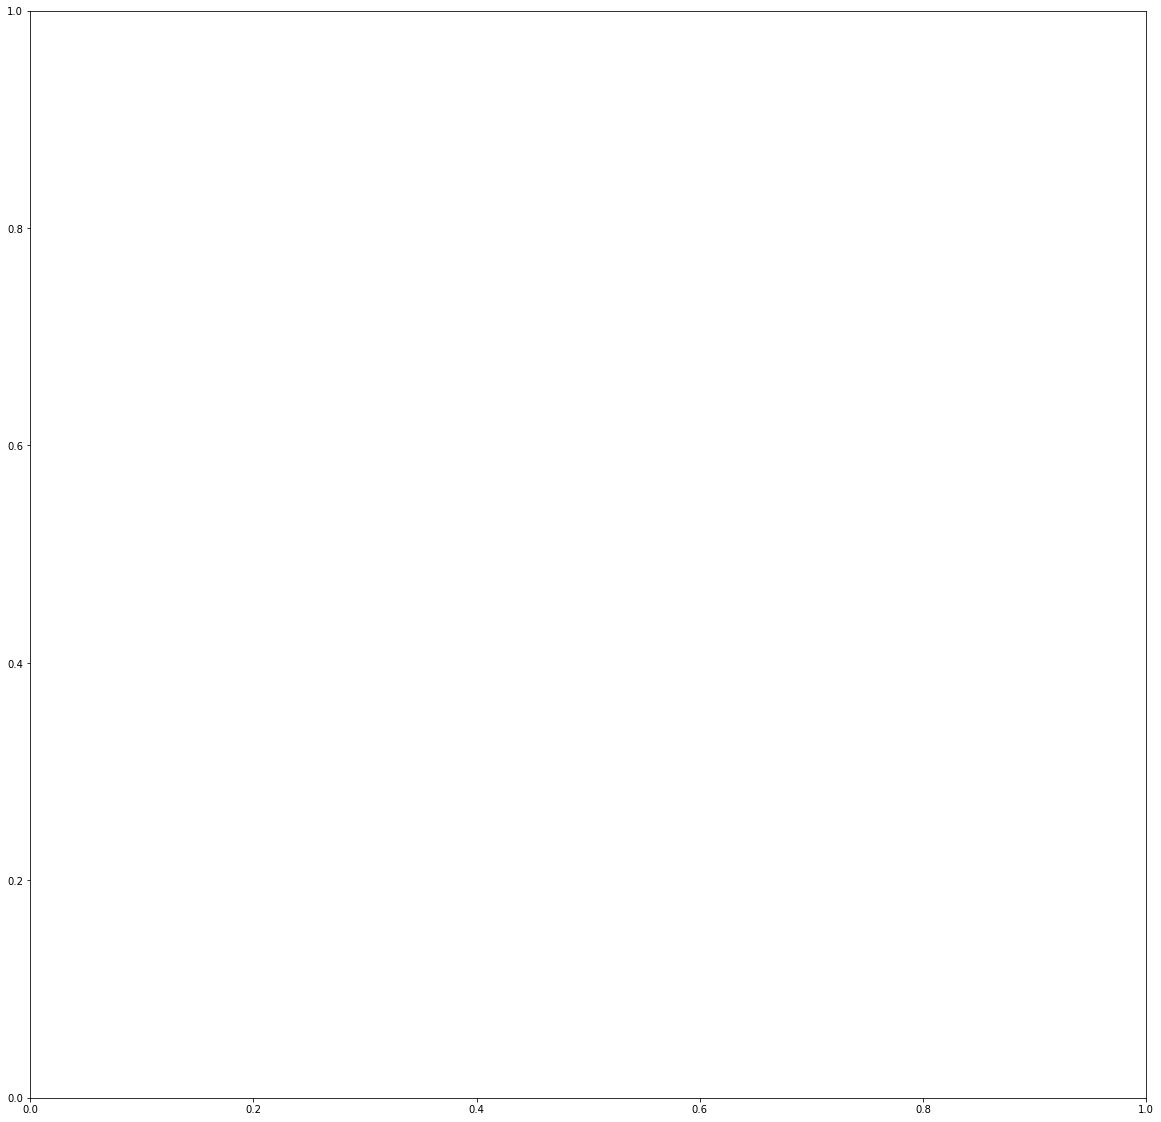

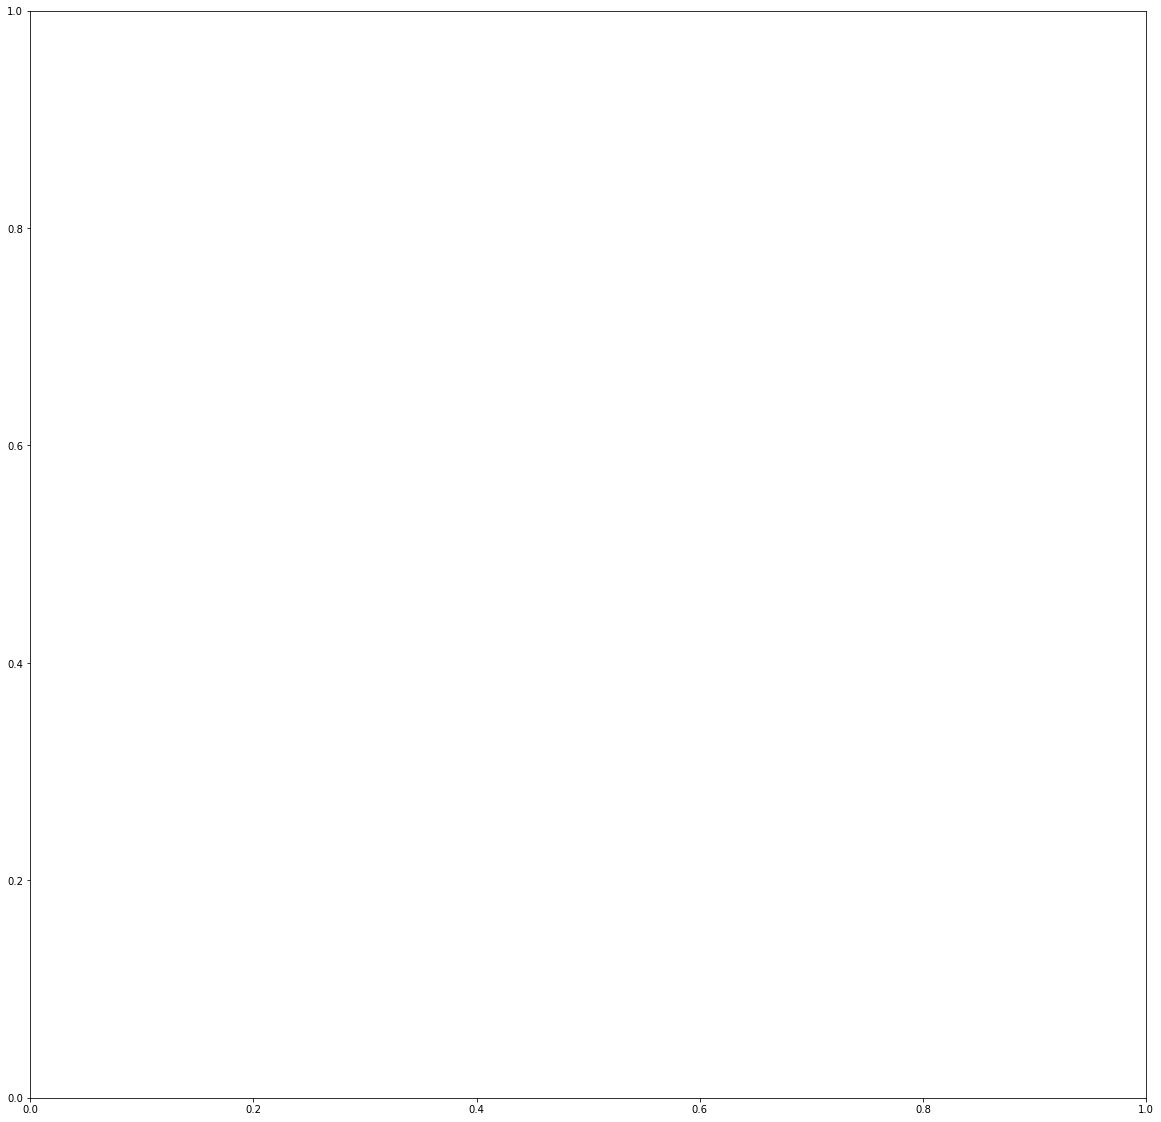

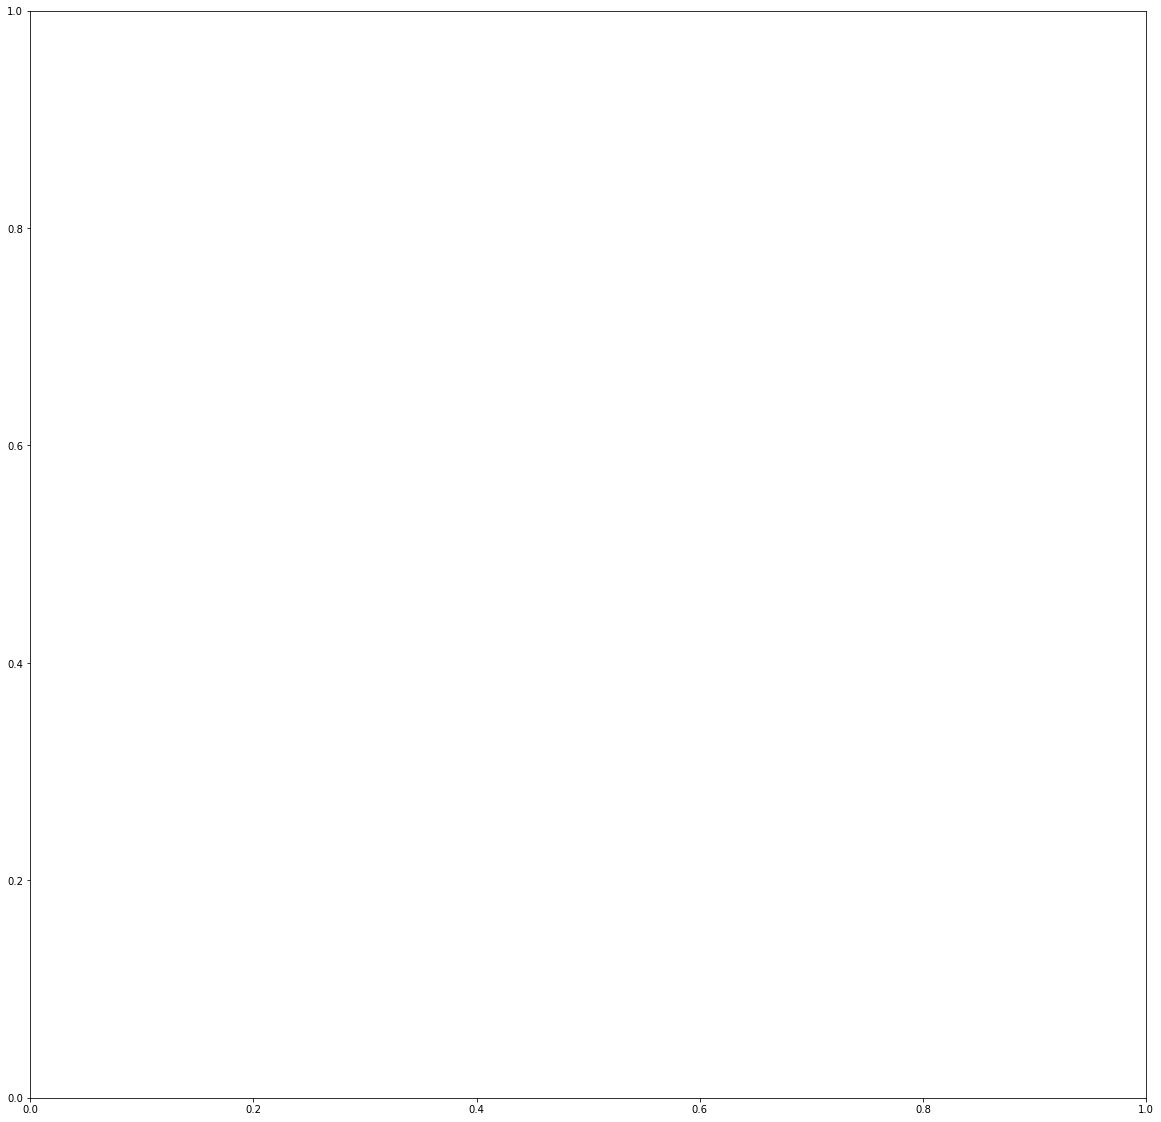

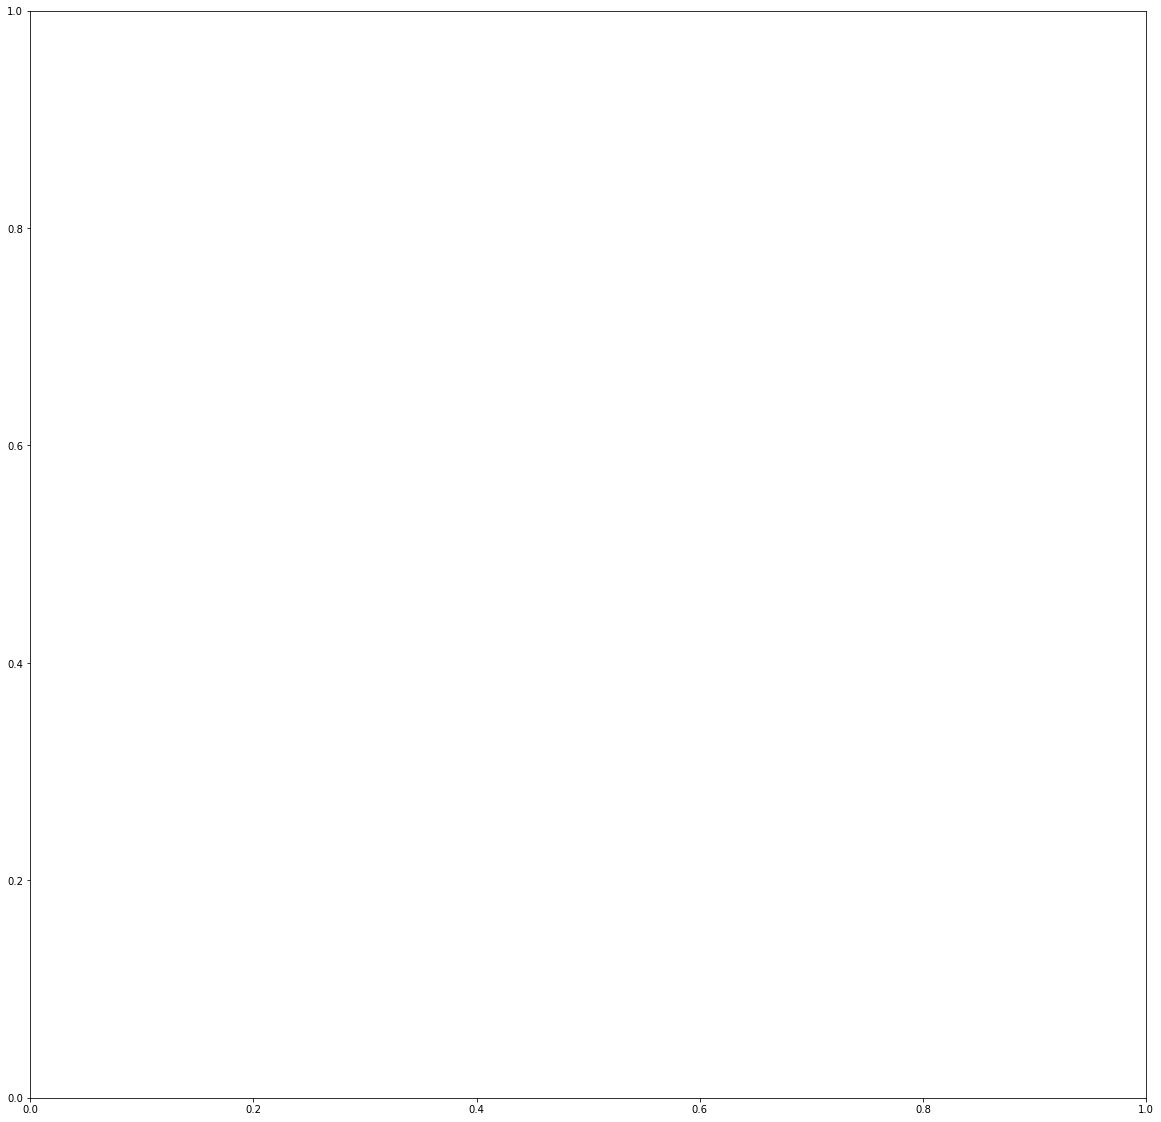

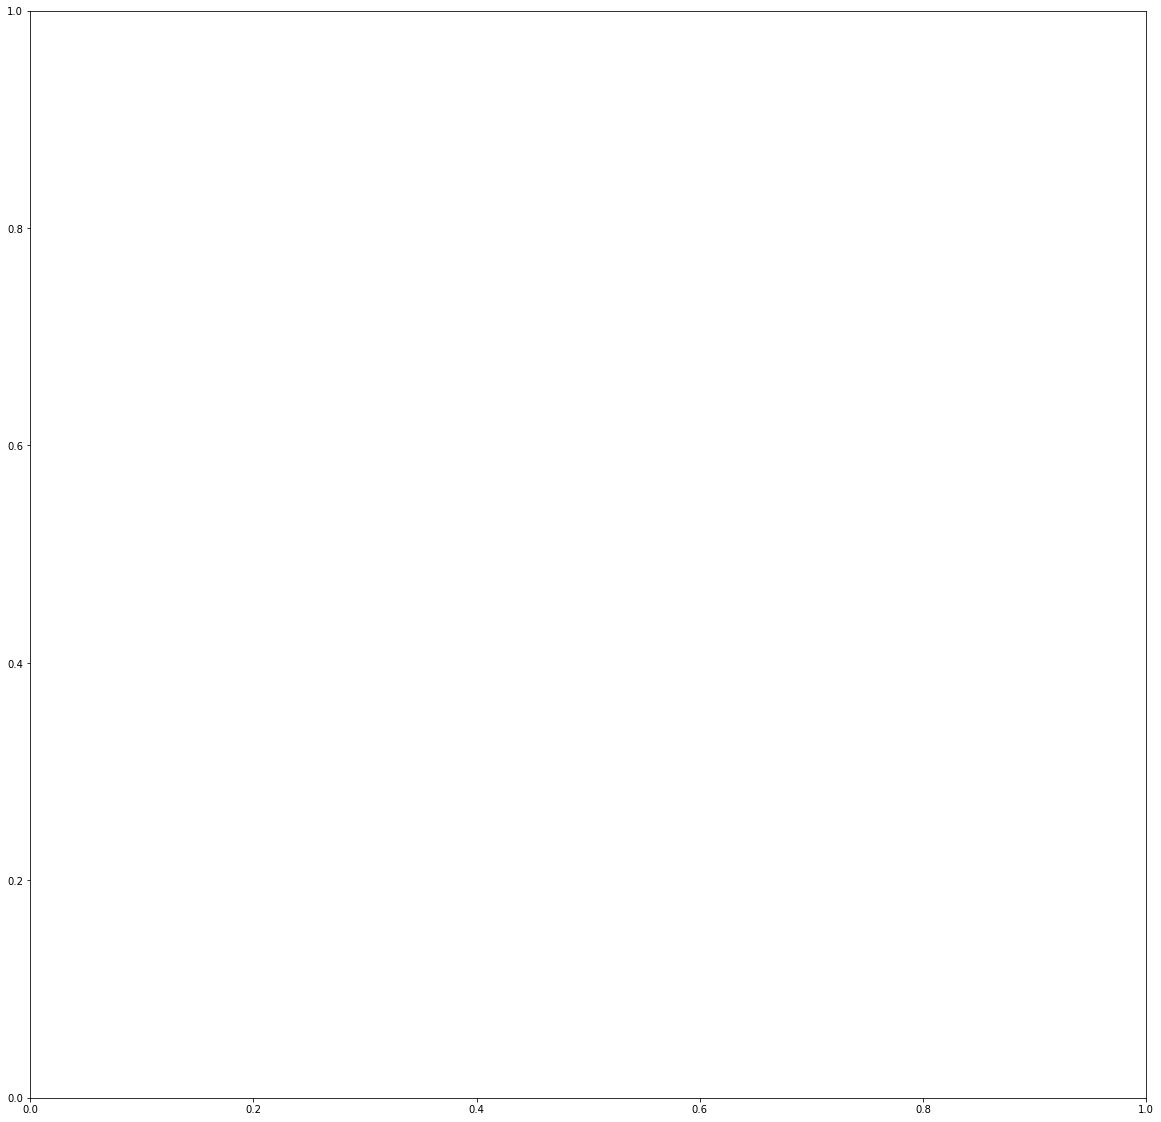

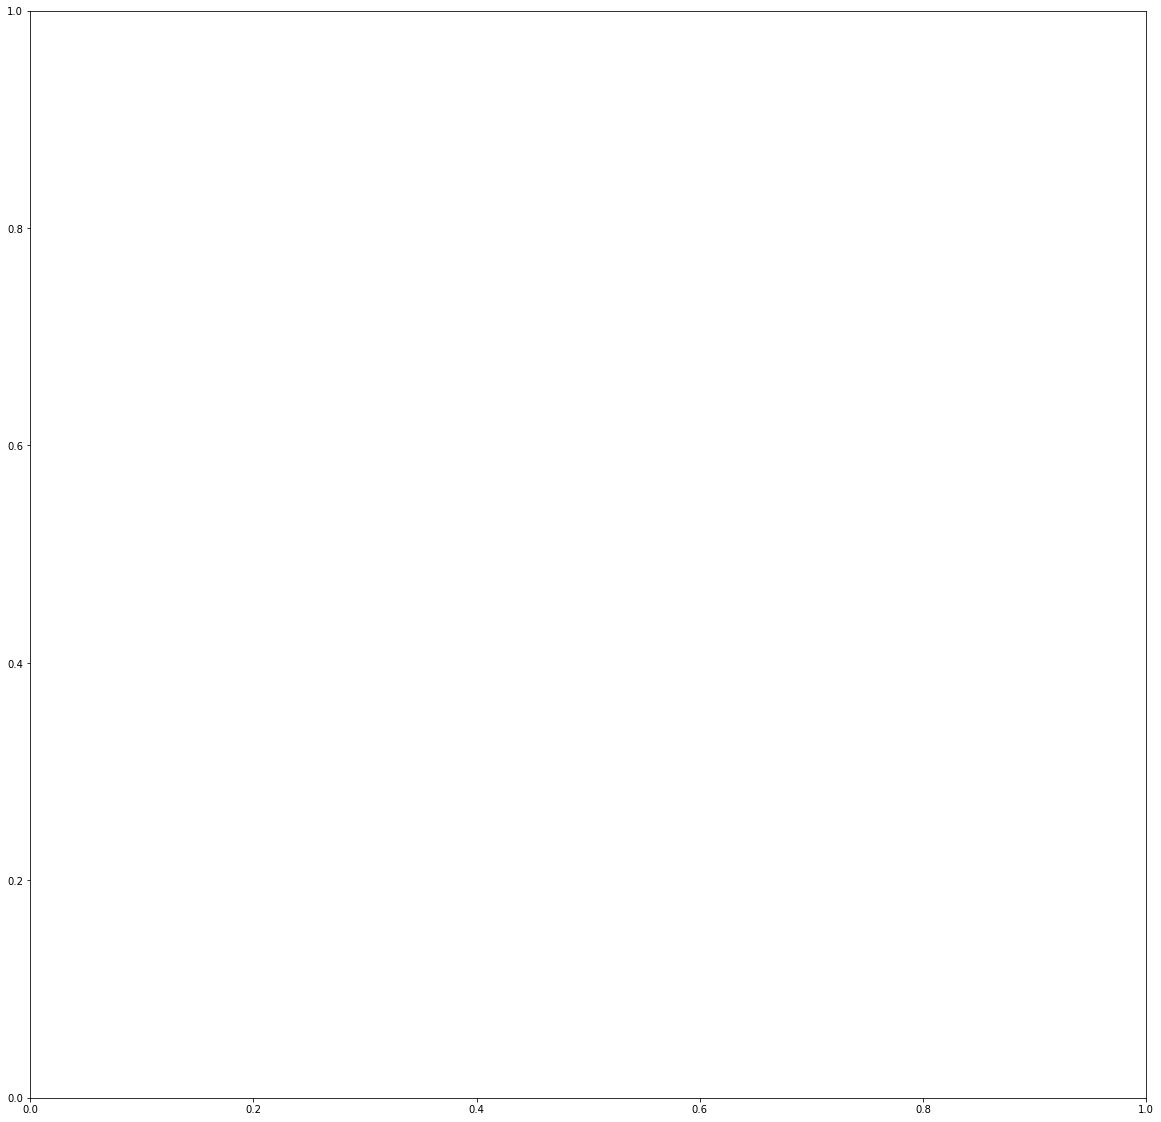

In [93]:
a = loadData(QC_imputed=True,Normalized=False,Log1p=False) #We want to use raw data

for j,stage in enumerate(a.obs["stage"].unique()[:]):

    b = a[a.obs["stage"]==stage]
    
    data = pd.read_csv("Tables/5_Clustering/Clusters.csv",index_col=0)
    b.obs["louvain"] = data.loc[b.obs.index.astype(int),"Louvain"].values.astype("str")
    
    scp.tl.rank_genes_groups(b,groupby="louvain",method="wilcoxon",use_raw=False)
    n_genes = 200
    
    if not os.path.exists("Tables/5_Clustering/DE_Genes_"+stage): #Make if it does not exist
        os.makedirs("Tables/5_Clustering/DE_Genes_"+stage)
        
    for k,group in enumerate(b.uns["rank_genes_groups"]["names"].dtype.names):
            
        l = pd.DataFrame(columns=["names","logfoldchanges","pvals","pvals_adj","scores"])
        l.loc[:,"names"] = b.var.loc[[n[k] for n in b.uns["rank_genes_groups"]["names"]][:n_genes],"Gene"].values
        l.loc[:,"logfoldchanges"] = [n[k] for n in b.uns["rank_genes_groups"]["logfoldchanges"]][:n_genes]
        l.loc[:,"pvals"] = [n[k] for n in b.uns["rank_genes_groups"]["pvals"]][:n_genes]
        l.loc[:,"pvals_adj"] = [n[k] for n in b.uns["rank_genes_groups"]["pvals_adj"]][:n_genes]
        l.loc[:,"scores"] = [n[k] for n in b.uns["rank_genes_groups"]["scores"]][:n_genes]
        
        l.to_csv("Tables/5_Clustering/DE_Genes_"+stage+"/Cluster_"+group+".csv")
    
    X = np.load("dataOut/4_Batch_Correction/UMAP_harmony_"+stage+".npy")
    
    if not os.path.exists("Plots/5_Clustering/Genes_"+stage): #Make if it does not exist
        os.makedirs("Plots/5_Clustering/Genes_"+stage)
    
    exp = []
    for k in geneList:
        try:
            fig,ax = plt.subplots(1,1,figsize=[20,20])
            hue = b[:,b.var.loc[:,"Gene"]==k].X.toarray()[:,0]
            pos = np.argsort(hue)

            sb.scatterplot(X[pos,0],X[pos,1],hue=hue[pos],s=50,ax=ax)
            ax.set_title(k,fontsize=40)
            fig.savefig("Plots/5_Clustering/Genes_"+stage+"/"+k+".png",bbox_inches="tight",transparent=False)
            plt.close(fig)
        except:
            if k not in exp:
                exp.append(k)
            
print(exp, " don't express")

# Annotate plots

After the clusters are annotated. We plot the annotation results over the UMAP

In [94]:
for j,i in enumerate(a.obs["stage"].unique()[:]):
    
    try:
        names = pd.read_csv(i+".csv",sep=";")
        names.columns = ["Number","Name"]
        names.drop(0,inplace=True)
        names["Number"] = names["Number"].astype(int)
        names.set_index("Number",inplace=True)

        b = scp.read("ManipulatedData/"+par.METRIC+"/Doublets_after"+i+".h5ad")   
        b.obs["Louvain"] = np.load("./ManipulatedData/"+par.METRIC+"/tables/clusters_louvain_r"+str(resolution)+"_"+i+".npy")
        b.obs["Louvain_Annotations"] = names.loc[b.obs["Louvain"].astype(int),"Name"].values 

        s = b.obs.groupby(["celltype","Louvain_Annotations"]).size().unstack()
        s = (s/s.sum(axis=0)).round(2)

        #fig,ax = plt.subplots(1,1,figsize=[20,20])
        sb.clustermap(s,annot=True)
        plt.savefig("Alfonso/Overlap"+i+".png")
        plt.close()
        
        #Plot clusters
        fig,ax = plt.subplots(1,1,figsize=[20,20])
        X = b.obsm["X_umap"]
        sb.scatterplot(X[:,0],X[:,1],hue=b.obs.loc[:,"Louvain"],s=50,ax=ax)
        ax.set_title(i,fontsize=40)
        for k in b.obs["Louvain"].unique():
            pos = b[b.obs["Louvain"]==k,:].obsm["X_umap"]
            pos = np.nan_to_num(pos)
            pos = pos.mean(axis=0)
            n = names.loc[int(k),"Name"]
            ax.text(pos[0]-0.1*len(n),pos[1],n,fontsize=20,backgroundcolor="lightgrey")
        fig.savefig("./Alfonso/Clustering_annotated_"+i+".png",bbox_inches="tight",transparent=False)
        plt.close(fig)    
        
    except:
        print("No annotations for :", i)
        
plt.close(fig)

No annotations for : E6.5
No annotations for : E7.5
No annotations for : E6.75
No annotations for : E7.75
No annotations for : E7.0
No annotations for : E8.0
No annotations for : E8.5
No annotations for : mixed_gastrulation
No annotations for : E7.25
No annotations for : E8.25


# Plot annotations of Pijuan-Sala over our UMAP embeding

In [8]:
for j,i in enumerate(a.obs["stage"].unique()[:]):
    b = scp.read("ManipulatedData/"+par.METRIC+"/Doublets_after"+i+".h5ad")            

    hue = b.obs["celltype"]
    X = b.obsm["X_umap"]
    
    fig,ax = plt.subplots(1,1,figsize=[20,20])

    sb.scatterplot(X[:,0],X[:,1],hue=hue,s=50,ax=ax)
    ax.set_title(i,fontsize=40)
    ax.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.savefig("./Alfonso/Marioni_annotations_"+i+".png",bbox_inches="tight",transparent=False)
    plt.close(fig)    

In [91]:
for j,i in enumerate(a.obs["stage"].unique()[:]):
    b = scp.read("ManipulatedData/"+par.METRIC+"/Doublets_after"+i+".h5ad")            

    hue = b.obs["celltype"]
    keep = False*np.ones_like(hue).astype(bool)
    for j in np.unique(b.obs["celltype"]):
        l = (b.obs["celltype"] == j)
        if np.sum(l)/len(l) > 0.02:
            None
        else:
            hue.replace(j,"other",inplace=True)
                
    pos = np.argsort(hue)
    X = b.obsm["X_umap"]
    fig,ax = plt.subplots(1,1,figsize=[20,20])

    sb.scatterplot(X[pos,0],X[pos,1],hue=hue[pos],s=50,ax=ax)
    ax.set_title(i,fontsize=40)
    
    leg = []
    for l,k in enumerate([ll.get_text() for ll in ax.legend_.texts]):
        pos = b[hue==k,:].obsm["X_umap"]
        pos = np.nan_to_num(pos)
        pos = pos.mean(axis=0)
        ax.text(pos[0],pos[1],l,fontsize=20,backgroundcolor="grey")
        leg.append(str(l)+" "+k)

    ax.legend(leg,fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    fig.savefig("./Alfonso/Marioni_annotations_limited_"+i+".png",bbox_inches="tight",transparent=False)
    plt.close(fig)   